# SDV SYNTHETIC DATA GENERATION

## SETUP

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

## LOAD REAL DATA

In [ ]:
from ucimlrepo import fetch_ucirepo 

'''# metadata 
print(diabetes_130_us_hospitals_for_years_1999_2008.metadata) 
  
# variable information 
print(diabetes_130_us_hospitals_for_years_1999_2008.variables) '''
  
# fetch dataset 
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296) 
  
# data (as pandas dataframes) 
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features 
y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets 

# create complete real_data
diabetes = pd.DataFrame(X)
diabetes["readmitted"] = y

# visualize data
diabetes.head()

## EXPLORE & PREPROCESS REAL DATA

In [ ]:
# dimensions
print(f"Dimension: {diabetes.shape}")

In [ ]:
# detect sensitive columns by intuition by their name
print(f"\columns: {diabetes.columns}\n")

# identify identity sensible data: 
sensitive_column_names = ['race', 'gender', 'weight', 'admission_type_id','discharge_disposition_id','admission_source_id','payer_code', 'medical_specialty']
print(f"\nSensitive columns: {sensitive_column_names}\n")

###  Check columns values & distribution

In [204]:
# SINGLE COLUMN: check columns values & distribution
def visualize_columns_distributions(df):
    for col in df.columns:
        print(f"\n\nColumn: {col}")

        # Get value counts of data
        val_counts = df[col].value_counts(dropna = False)   

        # prepare to print more pretty way
        counts_df = pd.DataFrame({'Items': val_counts})    

        # Print 
        print(counts_df)
    
# call to columns_distibution function
visualize_columns_distributions(diabetes)    



Column: race
                 Items
Caucasian        76096
AfricanAmerican  19210
Other             3776
Hispanic          2037
Asian              641


Column: gender
        Items
Female  54705
Male    47055


Column: age
          Items
[70-80)   26065
[60-70)   22480
[50-60)   17256
[80-90)   17197
[40-50)    9685
[30-40)    3775
[90-100)   2793
[20-30)    1657
[10-20)     691
[0-10)      161


Column: admission_type_id
   Items
1  53986
3  18867
2  18480
6   5291
5   4785
8    320
7     21
4     10


Column: discharge_disposition_id
    Items
1   60231
3   13953
6   12902
18   3691
2    2128
22   1991
11   1642
5    1184
25    989
4     815
7     623
23    412
13    399
14    372
28    139
8     108
15     63
24     48
9      21
17     14
16     11
19      8
10      6
27      5
12      3
20      2


Column: admission_source_id
    Items
7   57490
1   29563
17   6781
4    3187
6    2264
2    1104
5     855
3     187
20    161
9     125
8      16
22     12
10      8
14      2
11  

###  Generalize 'Nan' race values to 'Other'

In [187]:
# Generalize Nan race as 'Other'
import numpy as np
diabetes.loc[diabetes["race"].isin([np.nan ,'Other']), "race"] = "Other"

# validate change
diabetes.race.value_counts() 

Caucasian          76099
AfricanAmerican    19210
Other               3779
Hispanic            2037
Asian                641
Name: race, dtype: int64

###  Remove 'Unknown/Invalid' gender values

In [188]:
# 'Unknown/Invalid' # only 3 registry, not possible to define gender, best option would be to remove them 
diabetes[diabetes['gender'] == 'Unknown/Invalid'] 

# removing  'Unknown/Invalid' gender data
print(f"Shape before drop: {diabetes.shape}")
diabetes = diabetes.drop(diabetes[diabetes["gender"] == 'Unknown/Invalid'].index)

# validating results (only 3 less)
print(f"Shape after drop: {diabetes.shape}")

Shape before drop: (101766, 48)
Shape after drop: (101763, 48)


###  Check for null values per column

In [ ]:
# nulls per columns (percentage)
diabetes.isna().sum() * 100 / len(diabetes)

###  Drop "weight" column

In [189]:
# remove weight column form dataframe 96.858387% null values
print(f"Columns before remove {len(diabetes.columns)}")
diabetes = diabetes.drop('weight', axis=1)
print(f"Columns after remove {len(diabetes.columns)}")

Columns before remove 48
Columns after remove 47


###  Check for variability

Columns that have only one value

In [190]:
# Drop columns without variability
def columns_without_variability(df):    
    """
    Function that is responsible to determine which columnns has no variability (those which has only 1 value).    
    Parameters:
        df (pd.DataFrame): The original DataFrame.

    Returns:
        list(): list of variables without variability.
    """    
    sobran = []

    cols = df.columns
    for col in cols:
        if len(df[col].unique()) < 2:
            sobran.append(col)

    return sobran

# obtener listado de columnas sin variabilidad en una lista
cols_without_variability = columns_without_variability(diabetes)

# remove columns without variabitly
print(f"Columns without variability: {cols_without_variability}")
print(f"Columns before remove {len(diabetes.columns)}")
diabetes = diabetes.drop(columns = cols_without_variability)
print(f"Columns after remove {len(diabetes.columns)}")

Columns without variability: ['examide', 'citoglipton']
Columns before remove 47
Columns after remove 45


Columns that have more than one value, but only a single instance for one of the values.

In [192]:
def determine_single_value_entries(df):
    rows_to_check = []  # List to hold the rows matching the criteria
    cols_to_check = []
    for col in df.columns:
        # Get the value counts for the column
        value_counts = df[col].value_counts()

        # Check if exactly one value has a count of 1
        if (value_counts == 1).sum() == 1:
            # Get the value that appears exactly once
            single_value = value_counts[value_counts == 1].index[0]
            # add column name
            cols_to_check.append(col)
            
            # Select rows where this single value appears
            matching_rows = df[df[col] == single_value]
            
            # Append these rows to the list
            rows_to_check.append(matching_rows)

    # Concatenate all the matching rows into a single dataframe (if needed)
    result_df = pd.concat(rows_to_check, ignore_index=True) if rows_to_check else pd.DataFrame()

    return result_df,cols_to_check

# determine single value entries
matching_rows_df,cols_to_check = determine_single_value_entries(diabetes)

# check data relevancy
print(f"Single value entries:")
for col in cols_to_check:
    print(f"\nColumns: {col}")
    print(diabetes[col].value_counts(dropna = False))


Single value entries:

Columns: admission_source_id
7     57492
1     29564
17     6781
4      3187
6      2264
2      1104
5       855
3       187
20      161
9       125
8        16
22       12
10        8
14        2
11        2
25        2
13        1
Name: admission_source_id, dtype: int64

Columns: payer_code
NaN    40255
MC     32439
HM      6274
SP      5007
BC      4655
MD      3532
CP      2531
UN      2448
CM      1937
OG      1033
PO       592
DM       549
CH       146
WC       135
OT        95
MP        79
SI        55
FR         1
Name: payer_code, dtype: int64

Columns: chlorpropamide
No        101677
Steady        79
Up             6
Down           1
Name: chlorpropamide, dtype: int64

Columns: acetohexamide
No        101762
Steady         1
Name: acetohexamide, dtype: int64

Columns: tolazamide
No        101724
Steady        38
Up             1
Name: tolazamide, dtype: int64

Columns: glimepiride-pioglitazone
No        101762
Steady         1
Name: glimepiride-pioglita

Remove no relevant columns & rows.

In [197]:
# Filter from matching_rows_df those only they have 1 Steady instances
steadys = ["metformin-pioglitazone","glimepiride-pioglitazone","acetohexamide"] 
val ="Steady"

# Filter rows where exactly one of the specified columns has the value 'Steady'
filtered_df = diabetes.loc[
    (diabetes[steadys[0]] == val).astype(int) +
    (diabetes[steadys[1]] == val).astype(int) +
    (diabetes[steadys[2]] == val).astype(int) == 1
]

# Remove rows and columns as they do not have variability after removing
print(f"Actual dimension: {diabetes.shape}")
print(f"Removing rows: {filtered_df.index}")
diabetes = diabetes.drop(filtered_df.index)
print(f"After dimension: {diabetes.shape}")
print("Checking column variability")
cols_without_variability = columns_without_variability(diabetes)
print(f"Removing columns: {cols_without_variability}")
diabetes = diabetes.drop(columns = cols_without_variability)
print(f"Later dimension: {diabetes.shape}")

Actual dimension: (101763, 45)
Removing rows: Int64Index([26086, 77130, 98649], dtype='int64')


###  Check dtype uniformity: 

In [ ]:
# data information
print(f"\nData information: {diabetes.dtypes}\n")

In [ ]:
# Numerical data comprobations
num_cols = diabetes.select_dtypes(include='int64')

# Check column values, correspond to dtypes
for cat in num_cols.columns:
    print(f"\nColumn: {cat} values: {diabetes[cat].unique()}")

### Change admission_type_id, discharge_disposition_id  &  admission_source_id  to categoricals

In [201]:
# admission_type_id, discharge_disposition_id  &  admission_source_id  are categorical no numericals. Change
cols_to_change = ["admission_type_id","discharge_disposition_id", "admission_source_id"]
diabetes[cols_to_change] =  diabetes[cols_to_change].astype(object)
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101760 entries, 0 to 101765
Data columns (total 42 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      101760 non-null  object
 1   gender                    101760 non-null  object
 2   age                       101760 non-null  object
 3   admission_type_id         101760 non-null  object
 4   discharge_disposition_id  101760 non-null  object
 5   admission_source_id       101760 non-null  object
 6   time_in_hospital          101760 non-null  int64 
 7   payer_code                61506 non-null   object
 8   medical_specialty         51815 non-null   object
 9   num_lab_procedures        101760 non-null  int64 
 10  num_procedures            101760 non-null  int64 
 11  num_medications           101760 non-null  int64 
 12  number_outpatient         101760 non-null  int64 
 13  number_emergency          101760 non-null  int64 
 14  numb

### Check numerical data

In [ ]:
# get updated list
num_cols = diabetes.select_dtypes(include='int64')

# Check column values, correspond to dtypes
for cat in num_cols.columns:
    print(f"\nColumn: {cat} values: {diabetes[cat].unique()}")

### Check categorical data 

In [ ]:
# optimize memory use changing object to string
categorical_cols = diabetes.select_dtypes('object').columns.tolist()

# Check column values, correspond to dtypes
for cat in categorical_cols:
    print(f"\nColumn: {cat} values: {diabetes[cat].unique()}")

In [ ]:
import itertools

# get categorical column pairs
categorical_col_pair = list(itertools.combinations(categorical_cols, 2))       

# visualize data relations
for pair in categorical_col_pair:
    print(f"\n{pair[0]} distribution per {pair[1]}")
    print(f"{diabetes.groupby(pair[0])[pair[1]].value_counts(dropna= False).unstack().fillna(0)}")

In [202]:
# save data
diabetes.to_parquet("./refined_file.parquet",engine="pyarrow")

## CORRECT INBALANCES

Examine the data distribution for potential imbalances, which will help determine the appropriate corrective actions.

In [205]:
def detect_imbalanced_columns(data, threshold=0.1):
    """
    Detect columns with imbalanced classes based on the given threshold.
    
    Parameters:
        data (pd.DataFrame): The DataFrame to check for imbalanced columns.
        threshold (float): The proportion threshold to detect imbalance. 
                           Default is 0.1 (10%). A class is considered imbalanced
                           if its proportion is below this threshold or above 1 - threshold.
                           
    Returns:
        imbalanced_cols (list): List of column names with imbalanced data.
    """
    imbalanced_cols = []
    
    for col in data.columns:
        value_counts = data[col].value_counts(normalize=True, dropna=False)     
        
        # Check if any class proportion is below the threshold or above (1 - threshold)
        if any((value_counts < threshold) | (value_counts > (1 - threshold))):
            imbalanced_cols.append(col)
    
    return imbalanced_cols

def show_values_proportions(df, col):
    """
    Create dataframe that helps to visualize value_counts and data proportion

    Parameters:
        df (pd.DataFrame): The DataFrame to filter data
        col (str): column to filter
                           
    Returns:
        null
    """
     
    # Combine proportions into a DataFrame for easy comparison
    data =  pd.DataFrame({
        'Values': df[col].value_counts(dropna=False),
        'Proportions': df[col].value_counts(normalize = True, dropna=False)
    }).fillna(0)

    # print data
    print(data)

# recover again data
diabetes = pd.read_parquet("./refined_file.parquet",engine="pyarrow")

# find invalances and print results
imbalanced_columns = detect_imbalanced_columns(diabetes, threshold= 0.1)
if imbalanced_columns:
    print(f"From: {len(diabetes.columns)} inbalance are: {len(imbalanced_columns)}")
    print(f"Imbalanced columns:{imbalanced_columns}")
    for col in imbalanced_columns:
        print(f"\nColumn: {col}")
        # print values
        show_values_proportions(diabetes, col)        

From: 42 inbalance are: 37
Imbalanced columns:['race', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'glyburide-metformin', 'glipizide-metformin', 'metformin-rosiglitazone']

Column: race
                 Values  Proportions
Caucasian         76096     0.747799
AfricanAmerican   19210     0.188778
Other              3776     0.037107
Hispanic           2037     0.020018
Asian               641     0.006299

Column: age
          Values  Proportions
[70-80)    26065     0.256142
[60-70)    22480     0.22

### Data Generalization 

In [ ]:
# copy original data to manipulate
df1  = diabetes.copy()

# COLUMN: "readmitted" 
col = "readmitted"
df1.loc[df1[col] != "NO", col] = "YES"
df1.loc[df1[col] == "NO", col] = "NO"

# visualize changes
print("Real:")
show_values_proportions(diabetes,col)
print("\nNew:")
show_values_proportions(df1,col)

In [ ]:
"""
COLUMN: "age" 
GENERALIZE TO
[0-20) == [0-10) & [10-20)
[20-40) == [20-30) & [30-40)
[40-60) == [40-50) & [50-60)
[60-80) == [60-70) & [70-80)
[80-100) == [80-90) & [90-100)
"""
col = "age"
df1.loc[(df1[col] == "[0-10)") | (df1[col] == "[10-20)"),col] = "[0-20)"
df1.loc[(df1[col] == "[20-30)") | (df1[col] == "[30-40)"),col]= "[20-40)"
df1.loc[(df1[col] == "[40-50)") | (df1[col] == "[50-60)"),col] = "[40-60)"
df1.loc[(df1[col] == "[60-70)") | (df1[col] == "[70-80)"),col] = "[60-80)"
df1.loc[(df1[col] == "[80-90)") | (df1[col] == "[90-100)"),col] = "[80-100)"

# visualize changes
print("Real:")
show_values_proportions(diabetes,col)
print("\nNew:")
show_values_proportions(df1,col)

In [ ]:
"""
COLUMN: time_in_hospital
GENERALIZE INTO 4 GROUPS
"""
col = "time_in_hospital"
df1.loc[(df1[col] == 1) | (df1[col] == 2) | (df1[col] == 3) | (df1[col] == 4) ,col] = "[1-4]"
df1.loc[(df1[col] == 5) | (df1[col] == 6) |  (df1[col] == 7) | (df1[col] == 8) ,col] = "[5-8]"
df1.loc[(df1[col] == 9) | (df1[col] == 10) | (df1[col] == 11) | (df1[col] == 12) ,col] = "[9-12]"
df1.loc[(df1[col] == 13) | (df1[col] == 14) | (df1[col] == 15) | (df1[col] == 16) ,col] = "[13-16]"

# visualize changes
print("Real:")
show_values_proportions(diabetes,col)
print("\nNew:")
show_values_proportions(df1,col)

In [ ]:
# Generalize number_outpatient in two groups
col = "number_outpatient"
col1 = "outpatient"
df1.loc[df1[col] != 0, col1] = "YES"
df1.loc[df1[col] == 0, col1] = "NO"

# visualize changes
print("Real:")
show_values_proportions(diabetes,col)
print("\nNew:")
show_values_proportions(df1,col1)

In [ ]:
# Generalize number_impatient in two groups
col = "number_inpatient"
col1 = "inpatient"
df1.loc[df1[col] != 0, col1] = "YES"
df1.loc[df1[col] == 0, col1] = "NO"

# visualize changes
print("Real:")
show_values_proportions(diabetes,col)
print("\nNew:")
show_values_proportions(df1,col1)

In [ ]:
# Generalize num_procedures in two groups
col = "num_procedures"
col1 = "procedures"
df1.loc[df1[col] != 0, col1] = "YES"
df1.loc[df1[col] == 0, col1] = "NO"

# visualize changes
print("Real:")
show_values_proportions(diabetes,col)
print("\nNew:")
show_values_proportions(df1,col1)

In [ ]:
# Generalize number_emergency in two groups
col = "number_emergency"
col1 = "emergencies"
df1.loc[df1[col] != 0, col1] = "YES"
df1.loc[df1[col] == 0, col1] = "NO"

# visualize changes
print("Real:")
show_values_proportions(diabetes,col)
print("\nNew:")
show_values_proportions(df1,col1)

In [ ]:
# Generalize number_emergency in two groups
col = "number_diagnoses"
df1.loc[(df1[col] == 1) | (df1[col] == 2) | (df1[col] == 3) | (df1[col] == 4) |
        (df1[col] == 5) | (df1[col] == 6)  | (df1[col] == 7) | (df1[col] == 8),col] = "[0-8]"
df1.loc[(df1[col] == 9) | (df1[col] == 10) | (df1[col] == 11) | (df1[col] == 12) |
        (df1[col] == 13) | (df1[col] == 14)  | (df1[col] == 15) | (df1[col] == 16),col] = "[9-16]"

# visualize changes
print("Real:")
show_values_proportions(diabetes,col)
print("\nNew:")
show_values_proportions(df1,col1)

In [ ]:
# drop original columns 
col_list = ["number_emergency","num_procedures","number_inpatient",
            "number_outpatient","time_in_hospital", "age","readmitted","number_diagnoses"]

print(f"Column length after: {len(df1.columns)} to eliminate: {len(col_list)}")
df1 = df1.drop(col_list, axis=1)
print(f"Column length now: {len(df1.columns)}")

In [132]:
# save generalized data
df1.to_parquet("./generalized_file.parquet",engine="pyarrow")

### Balance data distribution

Race, admission_type_id

## CREATE SYNTHETIZER & SYNTHETIC DATA WITH SDV

In [ ]:
# Transform dataframe into`SingleTableMetadata` data type 
from sdv.metadata import SingleTableMetadata

def create_and_modify_metadata(df):
    """
    SingleTableMetadata type data creation. Obtains information directly from original dataframe and
    adjust dtype for "_id" type columns.
    
    Parameters:
        df (pd.DataFrame): The original DataFrame.

    Returns:
        SingleTableMetadata: metadata to create synthetic data
    """
    # Automatically detect metadata from the actual DataFrame
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(df)

    # Change dtype of "_id" columns. Threat as categorical instead of numerical
    for column_name in metadata.columns:
        if '_id' in column_name:
            metadata.update_column(column_name, sdtype='categorical')
    return metadata

# create metadata
# recover refined or preprocessed file
diabetes = pd.read_parquet("./refined_file.parquet",engine="pyarrow")
metadata = create_and_modify_metadata(diabetes)

# Check if metadata has been correctly generated
print(metadata)	


In [4]:
from sdv.single_table import GaussianCopulaSynthesizer

# Create synthetizer and synthetic data 
def synthetic_data_creation(md, df):
    """
    Creates synthetizer, trains synthetizer with real data and creates new 
    synthetic data.
    
    Parameters:
        md (SingleTableMetadata): Metadata of DataFrame.
        df (pd.DataFrame): The original DataFrame.

    Returns:
        SingleTableMetadata: metadata to create synthetic data
    """

    # create synthetizer
    synthesizer = GaussianCopulaSynthesizer(
        md,
        enforce_min_max_values=True,
        enforce_rounding=True) 

    # train data to learn from real data
    synthesizer.fit(
        data = df
    )

    # create new data (same dimensions) based on learned model
    synthetic_data = synthesizer.sample(
        num_rows=df.shape[0]
    )
    return synthetic_data

# obtain synthetic data
synthetic_data = synthetic_data_creation(metadata, diabetes)

## EXPLORE SYNTHETIC DATA AND VALIDATE

In [ ]:
# dimensions
print(f"Real dimension: {diabetes.shape}")
print(f"Synth dimension: {synthetic_data.shape}")

In [6]:
# Get information from both datasets
real_data_info = pd.DataFrame({
    'Column': diabetes.columns,
    'Real Non-Null Count':diabetes.notnull().sum()
})

# For synthetic data
synthetic_data_info = pd.DataFrame({
    'Column': synthetic_data.columns,
    'Synthetic Non-Null Count':synthetic_data.notnull().sum()
})

# Merge the two DataFrames on the 'Column' name
comparison = pd.merge(real_data_info, synthetic_data_info, on='Column', how='outer')

# Print comparison table
print("Comparison of Real and Synthetic Data:")
print(comparison)


Comparison of Real and Synthetic Data:
                      Column  Real Non-Null Count  Synthetic Non-Null Count
0                       race               101763                    101763
1                     gender               101763                    101763
2                        age               101763                    101763
3          admission_type_id               101763                    101763
4   discharge_disposition_id               101763                    101763
5        admission_source_id               101763                    101763
6           time_in_hospital               101763                    101763
7                 payer_code                61508                     64098
8          medical_specialty                51816                     87805
9         num_lab_procedures               101763                    101763
10            num_procedures               101763                    101763
11           num_medications               101763

### Identify Major Differences and Improve the Model

Analyze proportional differences and visualize them graphically for better insights.

In [45]:
def check_proportion_diffs(real, other, col, text):
    """
    Creates real and adjusted proportions values to compare
    
    Parameters:
        real (pd.DataFrame): The original DataFrame.
        other (pd.DataFrame): Dataframe to compare with original DataFrame
        col (str): The column to apply the comparison
        text (str): Text to apply comparison dataframe for comparative Dataframe

    Returns:       
        comparison_df pd.DataFrame: Dataframe that comparates real and other dataframes proportions
    """
    # Compute proportions for real and adjusted data
    real_proportions = real[col].value_counts(normalize=True).sort_index()
    other_proportions = other[col].value_counts(normalize=True).sort_index()
    
    # Combine proportions into a DataFrame for easy comparison
    comparison_df = pd.DataFrame({
        'Real': real_proportions,
         text: other_proportions
    }).fillna(0)

    # Calculate differences
    comparison_df['Absolute_Difference'] = comparison_df['Real'] - comparison_df[text]
    comparison_df['Relative_Difference'] = comparison_df['Absolute_Difference'] / comparison_df['Real'].replace(0, 1)  # Avoid division by zero

    return comparison_df

# Create and visualize data proportion
for col in diabetes.columns:
    print(f"\n Proportion differences for column '{col}':") 
    comparison_df= check_proportion_diffs(diabetes, synthetic_data, col, "Synthetic")
    print(comparison_df)


 Proportion differences for column 'race':
                     Real  Synthetic  Absolute_Difference  Relative_Difference
AfricanAmerican  0.188772   0.236196            -0.047424            -0.251223
Asian            0.006299   0.016214            -0.009915            -1.574103
Caucasian        0.747806   0.678842             0.068964             0.092222
Hispanic         0.020017   0.005365             0.014652             0.731959
Other            0.037106   0.063383            -0.026277            -0.708157

 Proportion differences for column 'gender':
            Real  Synthetic  Absolute_Difference  Relative_Difference
Female  0.537602   0.521653             0.015949             0.029667
Male    0.462398   0.478347            -0.015949            -0.034492

 Proportion differences for column 'age':
              Real  Synthetic  Absolute_Difference  Relative_Difference
[0-10)    0.001582   0.002398            -0.000816            -0.515528
[10-20)   0.006790   0.005768          

In [ ]:
import matplotlib.pyplot as plt

def compare_distributions(comparison_df, col, text):
    """
    Compare the distributions of a specific column in the real and adjusted DataFrames with visualizations.
    
    Parameters:
        comparison_df (pd.DataFrame): The DataFrame with proportion comparation between real and adjusted data.
        col (str): The column name to compare.
        text (str): Text to refer column that correspond to comparative data

    Returns:
        None
    """
    # Plotting
    plt.figure(figsize=(12, 6))
    comparison_df.plot(kind='bar', width=0.8)
    plt.title(f"Comparison of Proportions for '{col}'")
    plt.xlabel('Categories')
    plt.ylabel('Proportion')
    plt.xticks(rotation=45)
    plt.legend(['Real',text])
    plt.tight_layout()
    plt.show()
    
    
# Visualize comparison_df data
for col in diabetes.columns:
    print(f"\nColumn: {col}")    
    comparison_df= check_proportion_diffs(diabetes, synthetic_data, col, "Synthetic")
    compare_distributions(comparison_df[["Real","Synthetic"]], col, "Synthetic")
        

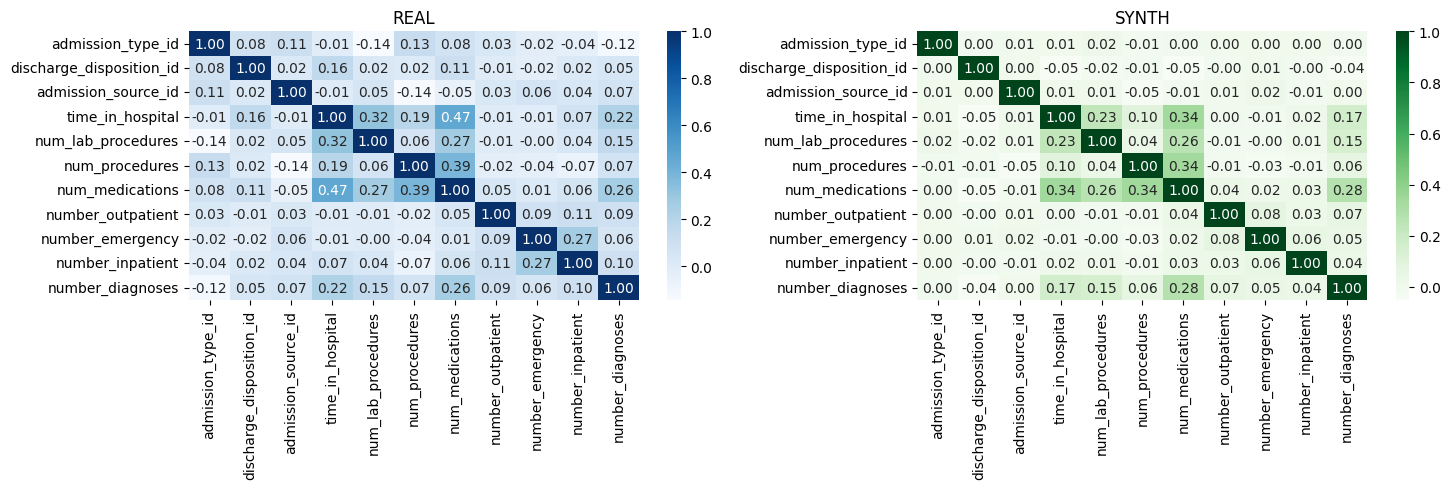

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# CORRELATION MATRIX
fig, ax = plt.subplots(1,2,figsize = (15,5))
corr_r = diabetes.corr()
corr_s = synthetic_data.corr()
sns.heatmap(corr_r, 
            xticklabels=corr_r.columns.values,
            yticklabels=corr_r.columns.values,
            cmap="Blues",
            annot=True,         # Display the correlation values in the cells
            fmt=".2f", ax = ax[0])
sns.heatmap(corr_s, 
            xticklabels=corr_s.columns.values,
            yticklabels=corr_s.columns.values,
            cmap="Greens",
            annot=True,         # Display the correlation values in the cells
            fmt=".2f", ax = ax[1])
ax[0].set_title("REAL")
ax[1].set_title("SYNTH")
plt.tight_layout()     
plt.show()

## ADJUST REAL DATA

Adjust the frequencies of categories in the real data to match the desired proportions. This may involve oversampling underrepresented categories or undersampling overrepresented ones.

In [ ]:
import pandas as pd
from sklearn.utils import resample

def adjust_data_distribution(df, col):
    """
    Adjust the distribution of a specific column in the DataFrame to match its real proportions.
    
    Parameters:
        df (pd.DataFrame): The original DataFrame.
        col (str): The column name to adjust.

    Returns:
        pd.DataFrame: The DataFrame with adjusted distribution for the specified column.
    """
    real_proportions = df[col].value_counts(normalize=True)
    adjusted_real_df = pd.DataFrame()
    
    for value, proportion in real_proportions.items():
        current_count = df[df[col] == value].shape[0]
        target_count = int(proportion * len(df))
        
        if target_count > current_count:
            # Oversample
            sample_df = df[df[col] == value]
            sampled_df = resample(sample_df, replace=True, n_samples=target_count - current_count)
            adjusted_real_df = pd.concat([adjusted_real_df, sample_df, sampled_df])
        elif target_count < current_count:
            # Undersample
            sampled_df = resample(df[df[col] == value], replace=False, n_samples=target_count)
            adjusted_real_df = pd.concat([adjusted_real_df, sampled_df])
        else:
            # No adjustment
            adjusted_real_df = pd.concat([adjusted_real_df, df[df[col] == value]])
    
    return adjusted_real_df


# Visualize adjusted data distribution 
for col in diabetes.columns:   
    # Adjust the real data
    adjusted_real_df = adjust_data_distribution(diabetes, col)
    
    # Comparate 
    comparison_df= check_proportion_diffs(diabetes, adjusted_real_df, col, "Adjusted_real")
    compare_distributions(comparison_df[["Real","Adjusted_real"]], col, "Adjusted_real")
    
    

In [58]:
for col in diabetes.columns:
    print("\n Column:{col}")
    print(diabetes[col].value_counts(dropna =False))


 Column:{col}
Caucasian          76099
AfricanAmerican    19210
Other               3776
Hispanic            2037
Asian                641
Name: race, dtype: int64

 Column:{col}
Female    54708
Male      47055
Name: gender, dtype: int64

 Column:{col}
[70-80)     26066
[60-70)     22482
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64

 Column:{col}
1    53988
3    18868
2    18480
6     5291
5     4785
8      320
7       21
4       10
Name: admission_type_id, dtype: int64

 Column:{col}
1     60232
3     13954
6     12902
18     3691
2      2128
22     1992
11     1642
5      1184
25      989
4       815
7       623
23      412
13      399
14      372
28      139
8       108
15       63
24       48
9        21
17       14
16       11
19        8
10        6
27        5
12        3
20        2
Name: discharge_disposition_id, dtype: int64

 Column:{col}
7     57492
1 

# Save adjusted data

In [25]:
# save data
adjusted_real_df.to_parquet("./adjusted.parquet",engine="pyarrow")

## RE-CREATE SYNTH DATA AND VALIDATE PERFORMANCE

In [ ]:
# TODO METADATA funtzioari deitu konpondutako dataset-akin

In [ ]:
# TODO SYNTH SORRERA funtzioari deitu konpondutako dataset-akin